In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt

# 오차역전파법 (BackPropagation)

* 계산 그래프를 이용하면 쉽게 이해할 수 있음. 

In [23]:
# 곱셈 계층
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None

    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x*y
        return out
    
    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x

        return dx, dy

In [24]:
apple = 100
apple_num = 2
tax = 1.1

mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# 순전파 과정
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

print("순전파")
print(price)
print("------------------")

# 역전파 과정
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print("역전파")
print(dapple, dapple_num, dtax)

순전파
220.00000000000003
------------------
역전파
2.2 110.00000000000001 200


In [25]:
# 덧셈 계층
class AddLayer:
    def __init__(self):
        pass

    def forward(self, x, y):
        out = x + y
        return out
    
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy

### ReLu

* $y = x (x > 0), 0 (x <= 0)$
* $y' = 1 (x > 0), 0 (x <= 0)$
* x가 0보다 크면 역전파 시 상류의 값을 그대로 하류로 보내고, 이하면 상류의 값을 하류로 보내지 않음

In [26]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        
        return dx

In [27]:
x = np.array([[1, -0.5], [-2, 3]])
print(x)

relu_layer = Relu()
f_relu = relu_layer.forward(x)
print(f_relu)

[[ 1.  -0.5]
 [-2.   3. ]]
[[1. 0.]
 [0. 3.]]


* mask는 True/False로 구성된 np배열임. x의 원소가 0 이하면 True, 아니면 False를 유지함
* 순전파 때 입력값을 이용해 만들어 둔 mask를 이용하여 역전파 때는 mask의 원소가 True인 곳에서는 상류에서 전파된 dout을 0으로 설정함

### Sigmoid
* $y = 1/(1+exp(-x))$


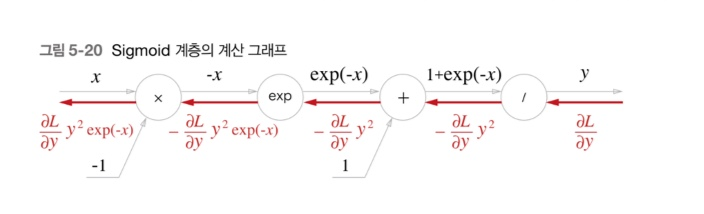

* $(dL/dy)*y^2exp(-x) = (dL/dy)*y(1-y)$

In [28]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out

        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx

In [29]:
sig_layer = Sigmoid()
f_sig = sig_layer.forward(x)
print(f_sig)

[[0.73105858 0.37754067]
 [0.11920292 0.95257413]]


### Affine
* 신경망의 순전파 때 수행하는 행렬의 곱을 Affine transformation이라고 함
* 이를 수행하는 처리를 'Affine계층' 이라는 이름으로 구현할 것임

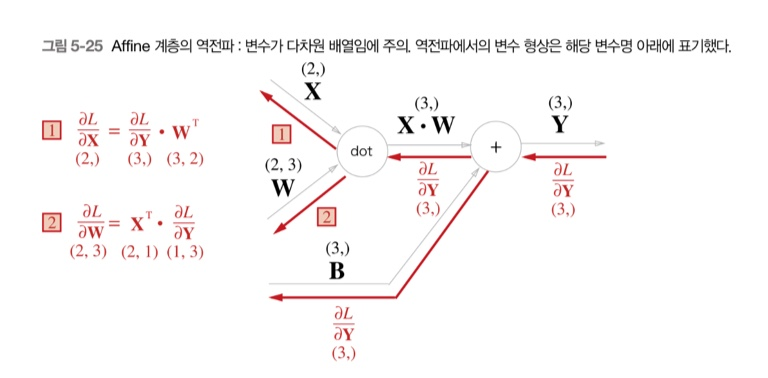

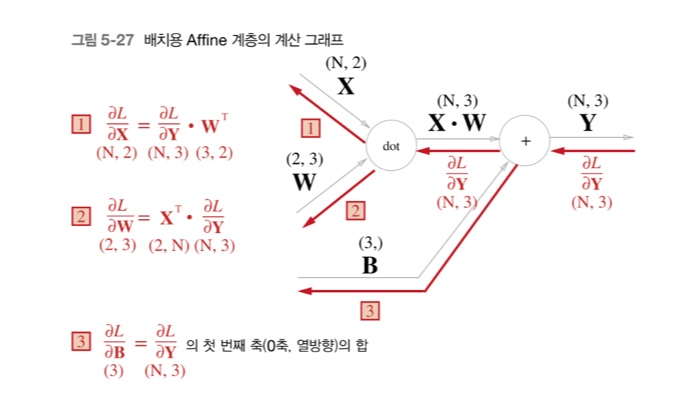
* broadcasting때문에 위와 같은 미분값이 나옴

In [ ]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx

### Softmax
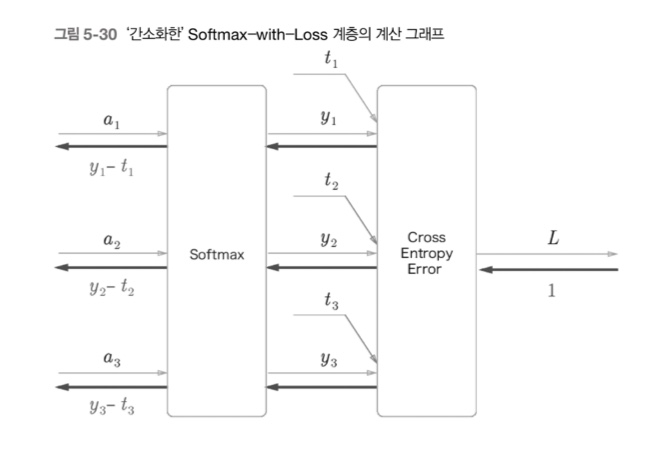


In [ ]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx
    
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size